### This code was written for the WiMLDS monthly meetup on February 20, 2020. This code presents examples and comparison of using SHAP and Lime for machine learning interpretability

Python Version: 3.6.8
Data Source: https://archive.ics.uci.edu/ml/datasets/Student+Performance

In [28]:
# Library imports
import shap
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

### Required to print the JS visualization code to the notebook

In [29]:
shap.initjs()

### Load data

In [30]:
student_data = pd.read_csv("student_data_prepped.csv")

### Review the distribution of passing grades for class imbalance

(array([233.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 162.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

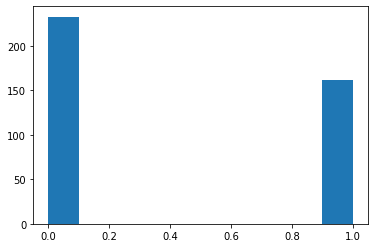

In [31]:
plt.hist(student_data.Pass)

### Classification using XGBoost

In [32]:
X = student_data.drop(['G3', 'Pass'], axis=1)
y = student_data['Pass']

# Split data into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

# Initialize and fit classifier
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
xgb_model.fit(X_train, y_train)

# Make predictions on test set
y_pred = xgb_model.predict(X_test)

### Print prediction results

In [33]:
print(confusion_matrix(y_test, y_pred))
print('')
print(accuracy_score(y_test, y_pred))

[[64  3]
 [ 1 31]]

0.9595959595959596


### Print a classification report to view accuracy metrics

In [34]:
print(classification_report(y_test, y_pred, target_names=['Fail', 'Pass']))

              precision    recall  f1-score   support

        Fail       0.98      0.96      0.97        67
        Pass       0.91      0.97      0.94        32

    accuracy                           0.96        99
   macro avg       0.95      0.96      0.95        99
weighted avg       0.96      0.96      0.96        99



### Model interpretation with SHAP

In [35]:
# explain the model's predictions using SHAP values
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_train)

### Visualize the first prediction's explanation 

In [36]:
# Force plots allow us to visualize individual model predictions. The “base value” is the model’s average prediction over the training data set
# Use link='logit' to see the probability of predicting 1, rather than seeing log-odds
shap.force_plot(explainer.expected_value, shap_values[0, :], X_train.iloc[0, :], link='logit')

# visualize the second prediction's explanation 
shap.force_plot(explainer.expected_value, shap_values[1, :], X_train.iloc[1, :], link='logit')

### Visualize the training set predictions

In [37]:
# Force plots can also allow us to visualize all model predictions at once. Think of this as individual force plots rotated vertically and stacked horizontally.
shap.force_plot(explainer.expected_value, shap_values, X_train, link='logit')

### Summary plot

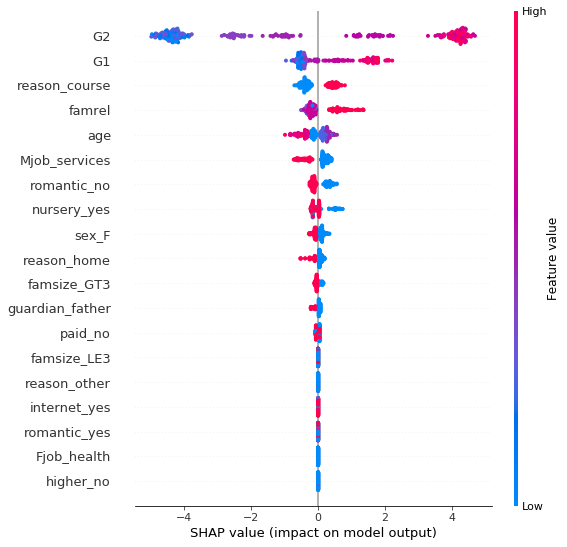

In [38]:
# A summary plot is an extension of a traditional feature importance plot. It details both feature importance AND feature effects. Each point on the plot is a Shapley value for a feature and an instance. 

shap.summary_plot(shap_values, X_train)

### Traditional variable importance plot

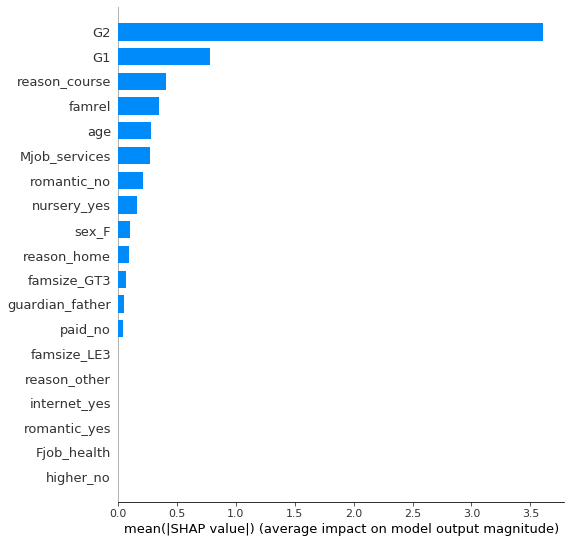

In [39]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

### Dependence plots showing the impact of individual and interaction features on SHAP values

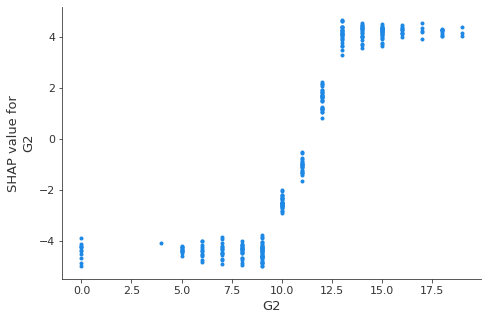

In [40]:
# A dependence plot is a scatter plot that shows the effect a single feature has on the predictions made by the model. 

shap.dependence_plot("G2", shap_values, X_train, interaction_index=None)

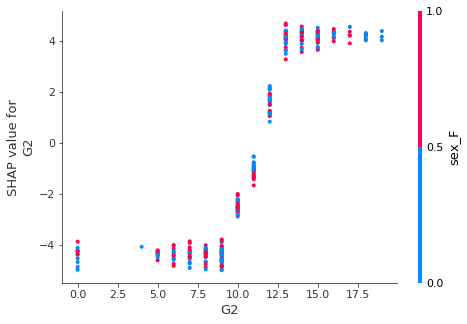

In [41]:
#The color corresponds to a second feature that may have an interaction effect with the feature we are plotting. If an interaction effect is present between this other feature and the feature we are plotting it will show up as a distinct vertical pattern of coloring. 

shap.dependence_plot("G2", shap_values, X_train, interaction_index="sex_F")

### Decision plot

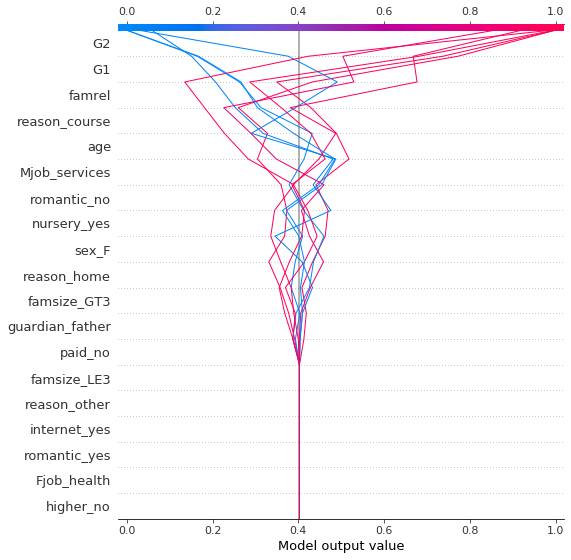

In [42]:
# Decision plots show how complex models arrive at their predictions (i.e., how models make decisions). 
    
select = range(20)
features = X_test.iloc[select]
features_display = X.loc[features.index]

# View decision plot for first 10 observations
shap.decision_plot(explainer.expected_value, shap_values[:10,:], features_display, link="logit")

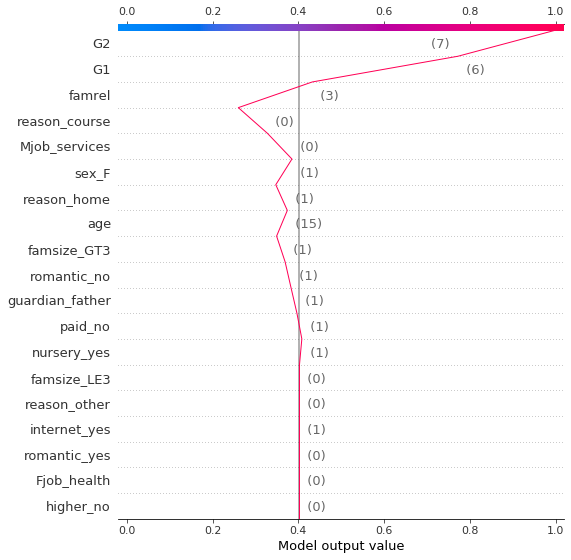

In [43]:
# View decision plot for first observation
shap.decision_plot(explainer.expected_value, shap_values[0,:], features_display, link="logit")